In [50]:
import math
import numpy as np
import wandb
import pickle

import sys
import os
import tqdm

import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader


import json
import joblib

# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath(os.path.join('..'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

# Now you can import the gnn_io module
import gnn_io as gio

import gnn_architectures as garch

model_path = "../../data/trained_models/model_16_07_new.pth"

## 1. Load 1pct data

In [51]:
# Load the list of dictionaries
data_1pct_testset = torch.load('../../data/test_data/dataset_1pct_0-400_more_features_target_is_difference_capacity_reduction_also_bc_capacity.pt')

# Reconstruct the Data objects
datalist = [Data(x=d['x'], edge_index=d['edge_index'], pos=d['pos'], y=d['y']) for d in data_1pct_testset]

scaler = joblib.load('../training/y_scaler.pkl')
dataset_normalized = gio.normalize_dataset(dataset=datalist, y_scalar=scaler)

In [52]:
test_dataset_1pct = gio.cut_dimensions(dataset=dataset_normalized, indices_of_dimensions_to_keep=[0, 1, 2, 3])
test_dl_1pct = gio.create_dataloader(dataset=test_dataset_1pct, is_train=False, batch_size=16, train_ratio=0, is_test=True)

Total dataset length: 350


## 2. Load 1pm test set

In [53]:
def load_dataset(file_path):
    return torch.load(file_path)

# Example usage
test_dataset = load_dataset('../training/test_dl_new.pt')

def load_dataloader_params(file_path):
    with open(file_path, 'r') as f:
        params = json.load(f)
    return params

test_loader_params = load_dataloader_params('../training/test_loader_params_new.json')

def create_dataloader(dataset, params):
    return DataLoader(
        dataset=dataset,
        batch_size=params['batch_size'],
        # shuffle=params['shuffle'],
        collate_fn=gio.collate_fn if params['collate_fn'] == 'collate_fn' else None  # Adjust as needed
    )

test_dl_1pm = create_dataloader(test_dataset, test_loader_params)

/Users/elenanatterer/anaconda3/envs/ml_env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [54]:
baseline_error_1pct = gio.compute_baseline_of_mean_target(test_dl_1pct)
print(f'Baseline error: {baseline_error_1pct}')

baseline_error_1pm = gio.compute_baseline_of_mean_target(test_dl_1pm)
print(f'Baseline error: {baseline_error_1pm}')

baseline_error_without_policy_1pct = gio.compute_baseline_of_no_policies(test_dl_1pct)
print(f'Baseline error: {baseline_error_without_policy_1pct}')

baseline_error_without_policy_1pm = gio.compute_baseline_of_no_policies(test_dl_1pm)
print(f'Baseline error: {baseline_error_without_policy_1pm}')

mean_y_normalized: 
0.5866133
median_y_normalized: 
0.56032723
Baseline error: 0.1407676786184311
mean_y_normalized: 
0.5642423
median_y_normalized: 
0.56032723
Baseline error: 0.0032576550729572773
Baseline error: 0.48488298058509827
Baseline error: 0.3216273784637451


In [55]:
test_dl_1pm.dataset

In [56]:
import torch
import joblib
import numpy as np
from torch.utils.data import DataLoader

def process_dataloaders(dataloader, scaler):    
    all_original_predictions = []
    for dataset in dataloader.dataset:
        normalized_predictions_np = dataset.y.numpy()        
        # Inverse transform the predictions
        original_predictions_np = scaler.inverse_transform(normalized_predictions_np)
        all_original_predictions.append(original_predictions_np.flatten())
    print(len(all_original_predictions))

    # Convert back to tensor if needed
    original_predictions = torch.tensor(all_original_predictions)
    return original_predictions

original_predictions_dl_1pm = process_dataloaders(test_dl_1pm, scaler)
original_predictions_dl_1pct = process_dataloaders(test_dl_1pct, scaler)

388
350


In [57]:
original_predictions_dl_1pct.shape

torch.Size([350, 31635])

In [58]:
def load_model(model_path):
    # Load the saved model checkpoint
    checkpoint = torch.load(model_path)
    
    # Extract the state dictionary and configuration
    state_dict = checkpoint['state_dict']
    config = checkpoint['config']
    
    # Initialize the model with the configuration
    model = garch.MyGnn(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        hidden_size=config['hidden_size'],
        gat_layers=config['gat_layers'],
        gcn_layers=config['gcn_layers'],
        # output_layer=config['output_layer']
        output_layer='gat'
    )
    model.load_state_dict(state_dict)
    model.eval()  # Set the model to evaluation mode
    return model, config

# Load the model and configuration
model, config = load_model(model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Model initialized
MyGnn(
  (pointLayer): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ), global_nn=Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  ))
  (output_layer): GATConv(16, 1, heads=1)
)


In [59]:
wandb.login()
wandb.init(project="test-project")

# Load the model from the pickle file
# checkpoint = torch.load(model_path)

# state_dict = checkpoint['state_dict']
# config = checkpoint['config']

# # Recreate the model using the saved configuration
# loaded_gnn_instance = garch.MyGnn(
#     in_channels=config['in_channels'],
#     out_channels=config['out_channels'],
#     hidden_size=config['hidden_size'],
#     gat_layers=config['gat_layers'],
#     gcn_layers=config['gcn_layers'],
#     output_layer=config['output_layer']
# )

# # Load the state dictionary into the model
# loaded_model = loaded_gnn_instance.to(device)
# loaded_model.load_state_dict(state_dict)

# Extract the state dictionary and any other necessary components
# state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
# config = checkpoint.get('config', None)  # Assuming 'config' is stored in the checkpoint

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


test_loss,▁▁█▁█
test_loss,2.18957


## 4. Test the model

In [60]:
# Function to evaluate the model
def evaluate(model, test_dl, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    predicted_values =[]
    actual_values = []
    with torch.no_grad():  # Disable gradient computation
        for data in test_dl.dataset:
            inputs, targets = data.x.to(device), data.y.to(device)
            outputs = model(data.to(device))
            outputs_np = outputs.cpu().numpy()
            predicted_values.append(scaler.inverse_transform(outputs_np))
            targets_np = targets.cpu().numpy()
            actual_values.append(scaler.inverse_transform(targets_np))
            loss = torch.nn.MSELoss()(outputs, targets)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_dl)
    
    # Log the test loss to Wandb
    wandb.log({"test_loss": avg_test_loss})
    return avg_test_loss, predicted_values, actual_values

# Evaluate the loaded model
test_loss_1pm, predicted_inverted_1pm, actual_inverted_1pm = evaluate(model=model,test_dl= test_dl_1pm, device=device)
print(f'Test Loss 1pm: {test_loss_1pm}')
test_loss_pct, predicted_inverted_1pct, actual_inverted_1pct = evaluate(model, test_dl_1pct, device)
print(f'Test Loss 1pct: {test_loss_pct}')

Test Loss 1pm: 0.04479807853698731
Test Loss 1pct: 2.189571037888527


In [62]:
# Function to compute R^2
def compute_r2(model, test_dl, device):
    model.eval()  # Set the model to evaluation mode
    actual_vals = []
    predictions = []
    
    with torch.no_grad():  # Turn off gradients for validation
        for data in test_dl.dataset:
            inputs, targets = data.x.to(device), data.y.to(device)
            outputs = model(data.to(device))
            actual_vals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())

    actual_vals = np.array(actual_vals)
    predictions = np.array(predictions)
    
    # Calculate R^2
    sst = ((actual_vals - actual_vals.mean()) ** 2).sum()
    ssr = ((actual_vals - predictions) ** 2).sum()
    r2 = 1 - ssr / sst
    
    return r2

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
r2_score = compute_r2(model, test_dl_1pm, device)
print(f'R^2 score: {r2_score}')

R^2 score: 0.11394065618515015


In [ ]:
predicted_inverted_1pm[0].shape

(31216, 1)

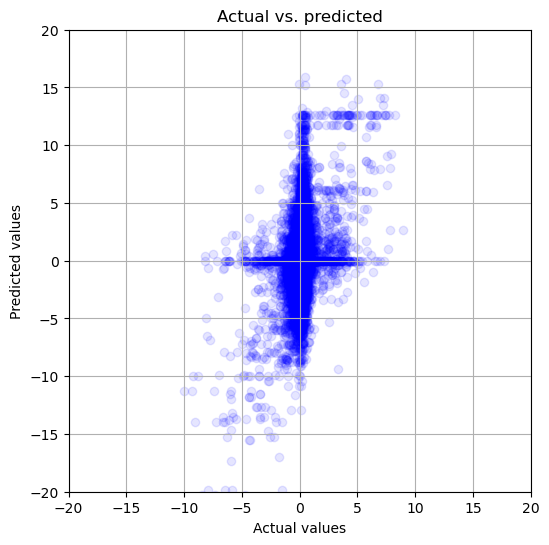

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays
x_values = predicted_inverted_1pm[1].flatten()
y_values = actual_inverted_1pm[1].flatten()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.1, color='blue')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. predicted')
plt.grid(True)

# Set the limits of both axes to be the same
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

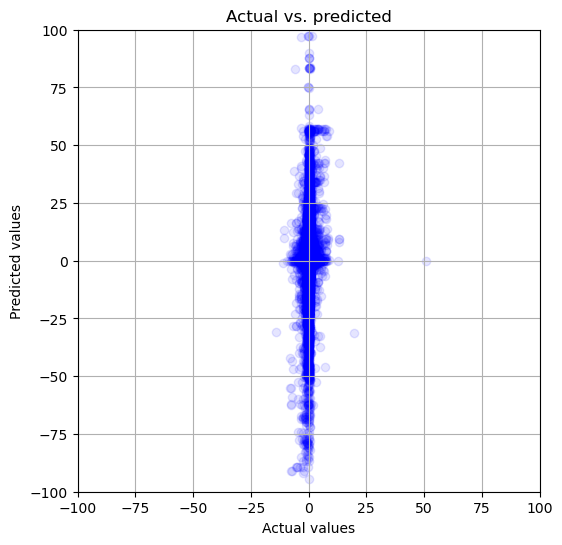

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays
x_values = predicted_inverted_1pct[0].flatten()
y_values = actual_inverted_1pct[0].flatten()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.1, color='blue')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. predicted')
plt.grid(True)

# Set the limits of both axes to be the same
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

ValueError: x and y must be the same size

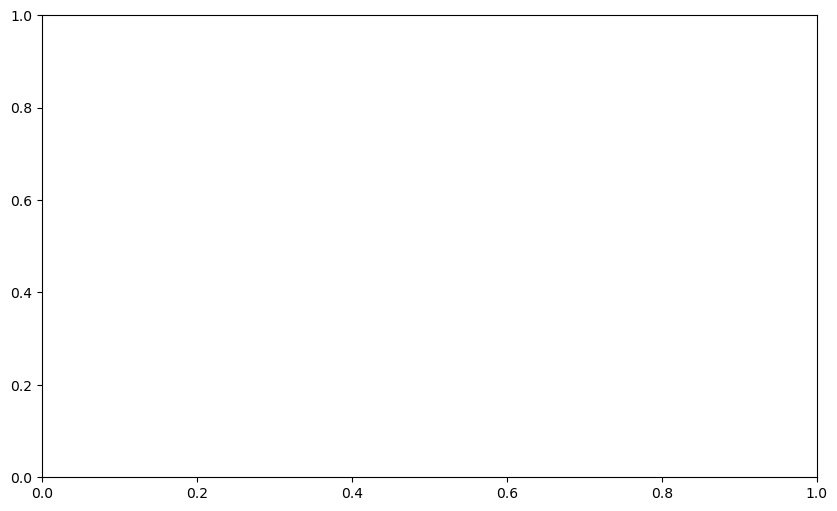

In [ ]:
# Convert tensors to numpy arrays
x_values = actual_inverted_1pm[0].flatten()
y_values = actual_inverted_1pct[0].flatten()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.1, color='blue')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. predicted')
plt.grid(True)

# Set the limits of both axes to be the same
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
x_values.shape

(31216,)

In [ ]:
actual_inverted_1pct[0].shape

(31635, 1)